<a href="https://colab.research.google.com/github/n1tz53/tooth-root-classification/blob/main/tooth_root_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Make Sure your drive is mounted and data is present in *Colab Notebooks* directory**

In [1]:
% cd "drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [2]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [3]:
# directory containing dental x-rays
dir = './Interns Assignment/xrays database/'

In [5]:
'''
keras image data generator api with real-time image augmentation
train-validation split of 70:30
'''

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, horizontal_flip=True, 
                                                             vertical_flip=True,
                                                             rotation_range=5, validation_split=0.3,
                                                             dtype=np.float32)
batch_size = 16
print('Training data generator:')
train_generator = train_datagen.flow_from_directory(dir, target_size=(210, 130), batch_size=batch_size, class_mode='binary', subset='training')
print('Validation data generator')
val_generator = train_datagen.flow_from_directory(dir, target_size=(210, 130), batch_size=batch_size, class_mode='binary', subset='validation')

Training data generator:
Found 81 images belonging to 2 classes.
Validation data generator
Found 34 images belonging to 2 classes.


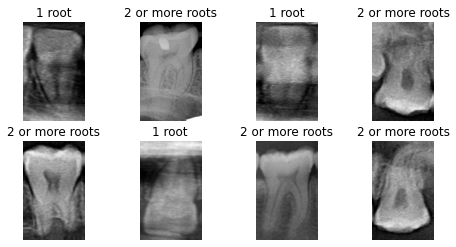

In [6]:
"""
display some augmented images
"""

def show_imgs(imgs, num_rows, num_cols, titles=None, scales=2):
  figsize = (num_cols * scales, num_rows * scales)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.set_axis_off()
    if len(titles) > 0:
      ax.set_title(titles[i])
  return

images, labels = next(train_generator)
class_names = {0.0: '1 root', 1.0: '2 or more roots'}
titles = list(map(lambda arg: class_names[arg], labels[:8]))
show_imgs(images[:8], 2, 4, titles=titles)

**Training Strategy**


1. Since number of training images are around 100 which is really less to train something from scratch, we will use transfer learning
2. Our base model for transfer learning will be CNN trained on CIFAR10 dataset given [here](https://www.tensorflow.org/tutorials/images/cnn)
3. We will also use basic image augmentation


##Pre-trained Model

In [7]:
# base model architecure
base_model = tf.keras.models.load_model('./base_model')
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

##Model Definition

In [8]:
'''
we will use original image size, will also include
two dropout layers for regularization
'''

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(210, 130, 3)))
for layer in base_model.layers[:6]:
  # freeze the layers taken from the base model
  layer.trainable = False
  model.add(layer)
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [9]:
'''
summary of our model
'''
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           multiple                  896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_13 (Conv2D)           multiple                  18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_14 (Conv2D)           multiple                  36928     
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dropout (Dropout)            (None, 90944)             0

In [10]:
'''
we will use mini-batch SGD for optimzation
and binary crossentrop for loss function
'''

model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# using early stopping to avoid overfitting

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')


In [12]:
# training the network
history = model.fit(x=train_generator, epochs=10, validation_data=val_generator, callbacks=model_checkpoint)

Epoch 1/10
6/6 [==============================] - 1s 168ms/step - loss: 0.6800 - accuracy: 0.6296 - val_loss: 0.6440 - val_accuracy: 0.8235
Epoch 2/10
6/6 [==============================] - 1s 145ms/step - loss: 0.6831 - accuracy: 0.6914 - val_loss: 0.6279 - val_accuracy: 0.7941
Epoch 3/10
6/6 [==============================] - 1s 142ms/step - loss: 0.6457 - accuracy: 0.7160 - val_loss: 0.6343 - val_accuracy: 0.6765
Epoch 4/10
6/6 [==============================] - 1s 144ms/step - loss: 0.6444 - accuracy: 0.7284 - val_loss: 0.6317 - val_accuracy: 0.7059
Epoch 5/10
6/6 [==============================] - 1s 145ms/step - loss: 0.6603 - accuracy: 0.6914 - val_loss: 0.6076 - val_accuracy: 0.8824
Epoch 6/10
6/6 [==============================] - 1s 142ms/step - loss: 0.6272 - accuracy: 0.7901 - val_loss: 0.6147 - val_accuracy: 0.8529
Epoch 7/10
6/6 [==============================] - 1s 143ms/step - loss: 0.6506 - accuracy: 0.7407 - val_loss: 0.6008 - val_accuracy: 0.8824
Epoch 8/10
6/6 [====

In [13]:
# choose the best weights based on previous history
model.load_weights('model.08-0.64.h5')

**Once we have train the Fully connected layer we will unfreeze the whole network and train on low learning rate**

In [14]:
# unfreeze all the layers
for layer in model.layers:
  layer.trainable = True

In [15]:
# complile again, with lower learning rate of 1e-6
model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-6),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# train again the whole network
history = model.fit(x=train_generator, epochs=5, validation_data=val_generator, callbacks=early_stopping)

Epoch 1/5
6/6 [==============================] - 1s 165ms/step - loss: 0.6443 - accuracy: 0.7778 - val_loss: 0.6345 - val_accuracy: 0.8235
Epoch 2/5
6/6 [==============================] - 1s 136ms/step - loss: 0.6499 - accuracy: 0.7654 - val_loss: 0.6381 - val_accuracy: 0.8235
Epoch 3/5
6/6 [==============================] - 1s 138ms/step - loss: 0.6360 - accuracy: 0.8025 - val_loss: 0.6290 - val_accuracy: 0.8235
Epoch 4/5
6/6 [==============================] - 1s 136ms/step - loss: 0.6393 - accuracy: 0.7531 - val_loss: 0.6328 - val_accuracy: 0.8235
Epoch 5/5
6/6 [==============================] - 1s 137ms/step - loss: 0.6458 - accuracy: 0.7531 - val_loss: 0.6306 - val_accuracy: 0.8235


**Prediction on some validation set images**

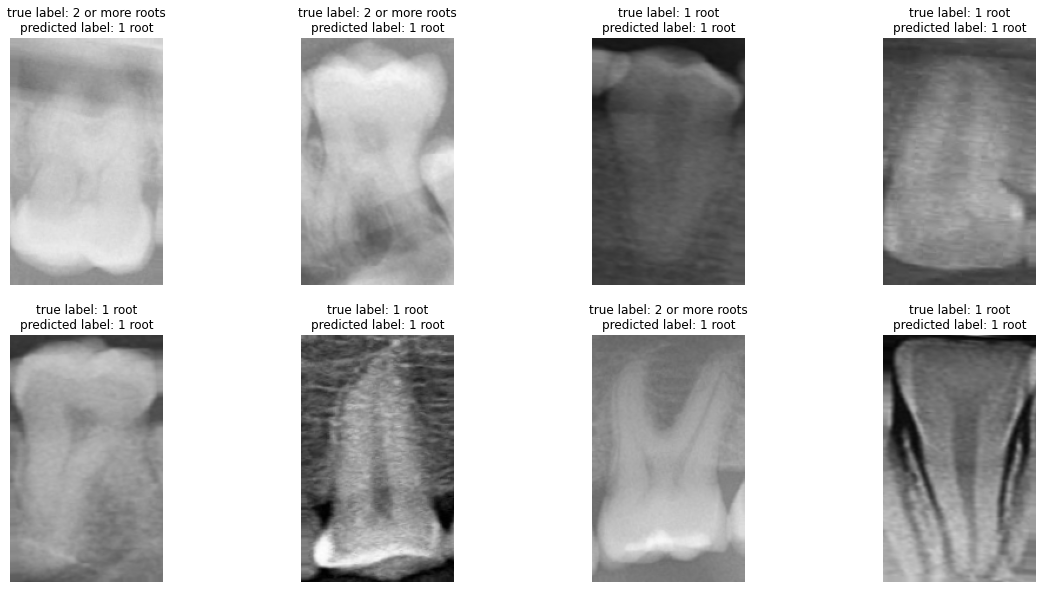

In [17]:
'''
predicted label/True label format
'''

fmt = 'true label: {1}\npredicted label: {0}'
images, labels = next(val_generator)
class_names = {0.0: '1 root', 1.0: '2 or more roots'}
actual = list(map(lambda arg: class_names[arg], labels))
predicted = model.predict_on_batch((images / 255.).astype(np.float32)).reshape(-1)
titles = [fmt.format(class_names[round(predicted[i])], actual[i]) for i in range(len(labels))]
show_imgs(images, 2, 4, titles=titles, scales=5)